In [272]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
require(vegan)
require(knitr)
require(ggpubr)
library(ggeffects)
library(janitor)
library(sjPlot)
library(visreg)
library(interactions)

In [273]:
setwd(here::here())

In [274]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")

In [306]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")
source("./R/function_emtrends_contrast_plot.R")


In [276]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 10)

__For running each peice of code press shift + Enter__

# __Q3:How do functional traits, treatment, and N-fixing status interact to influence seedling-level growth rates and biomass accumulation?__


In [277]:
# Select variables that are going to be used in the model
data_for_models <-
    data_for_models %>%

    clean_names() %>%
    # Select columns needed for regression
    dplyr::select(spcode, treatment, nfixer, init_height,

                  # Performance measures
                  total_biomass, rgr, root_shoot_ratio,

                  # physiology traits
                  amax, gs, wue,pnue,sla,

                  # Leaf traits
                  narea_g_m2) %>%
    clean_names()

## Regression models 

$$response\sim treatment*trait\ +nfixer*trait\ + initial\ height\ + random(1|specie)$$

In [279]:
data_plant_performance <-
    data_for_models %>%
        dplyr::select(-c(amax, gs,wue, narea_g_m2,	sla, pnue, init_height))

In [280]:
# Center and scale by 2 as Gelman et al 2008

data_traits_scaled_gelman <-
        data_for_models %>%
                dplyr::select(-c(total_biomass, rgr, root_shoot_ratio)) %>%
                mutate(across(where(is.numeric), arm::rescale))

In [281]:
data_for_regression_scaled_traits <-
    inner_join(data_plant_performance, data_traits_scaled_gelman, by = c("treatment","spcode", "nfixer"))

Warning message in inner_join(data_plant_performance, data_traits_scaled_gelman, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [282]:
# add t-ratio
emm_options(contrast = list(infer = c(TRUE, TRUE)))

### Total biomass

In [283]:
model_traits_total_biomass <- lmer(total_biomass ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * sla +
                                                treatment * pnue +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * sla +
                                                nfixer * pnue +


                            (1 |spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)


### Relative Growth Rate

In [284]:
model_traits_rgr <- lmer(rgr ~  treatment * amax +
                            treatment * gs  +
                            treatment * sla +
                            treatment * pnue +

                            nfixer * amax +
                            nfixer * gs  +
                            nfixer * sla +
                            nfixer * pnue +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

### Root to shoot ratio

In [285]:
model_traits_root_shoot <- lmer(root_shoot_ratio ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * sla +
                                                treatment * pnue +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * sla +
                                                nfixer * pnue +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

## Model Assumptions

[1] "No variable specified inthe variables argument"


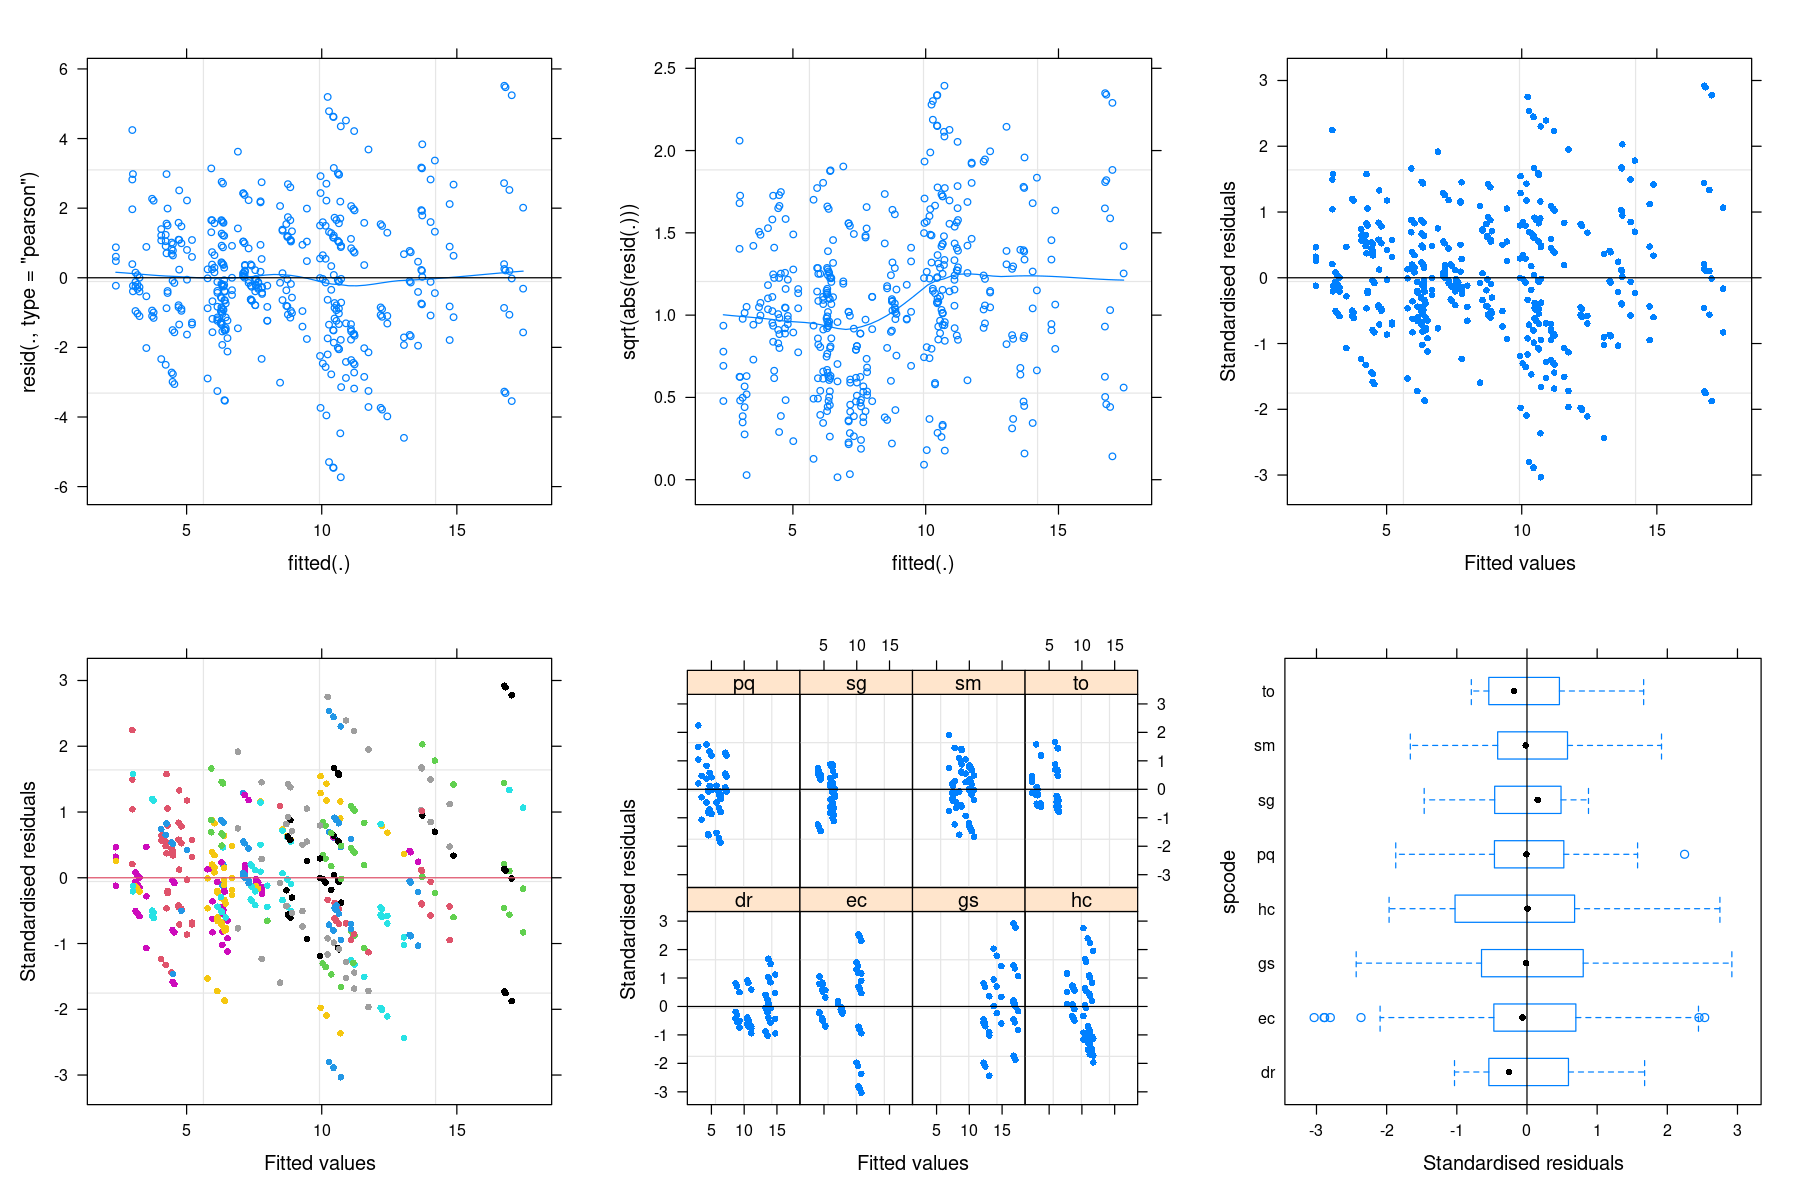

In [287]:
par(mfrow = c(3,3))
validation_plots(model_traits_total_biomass, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


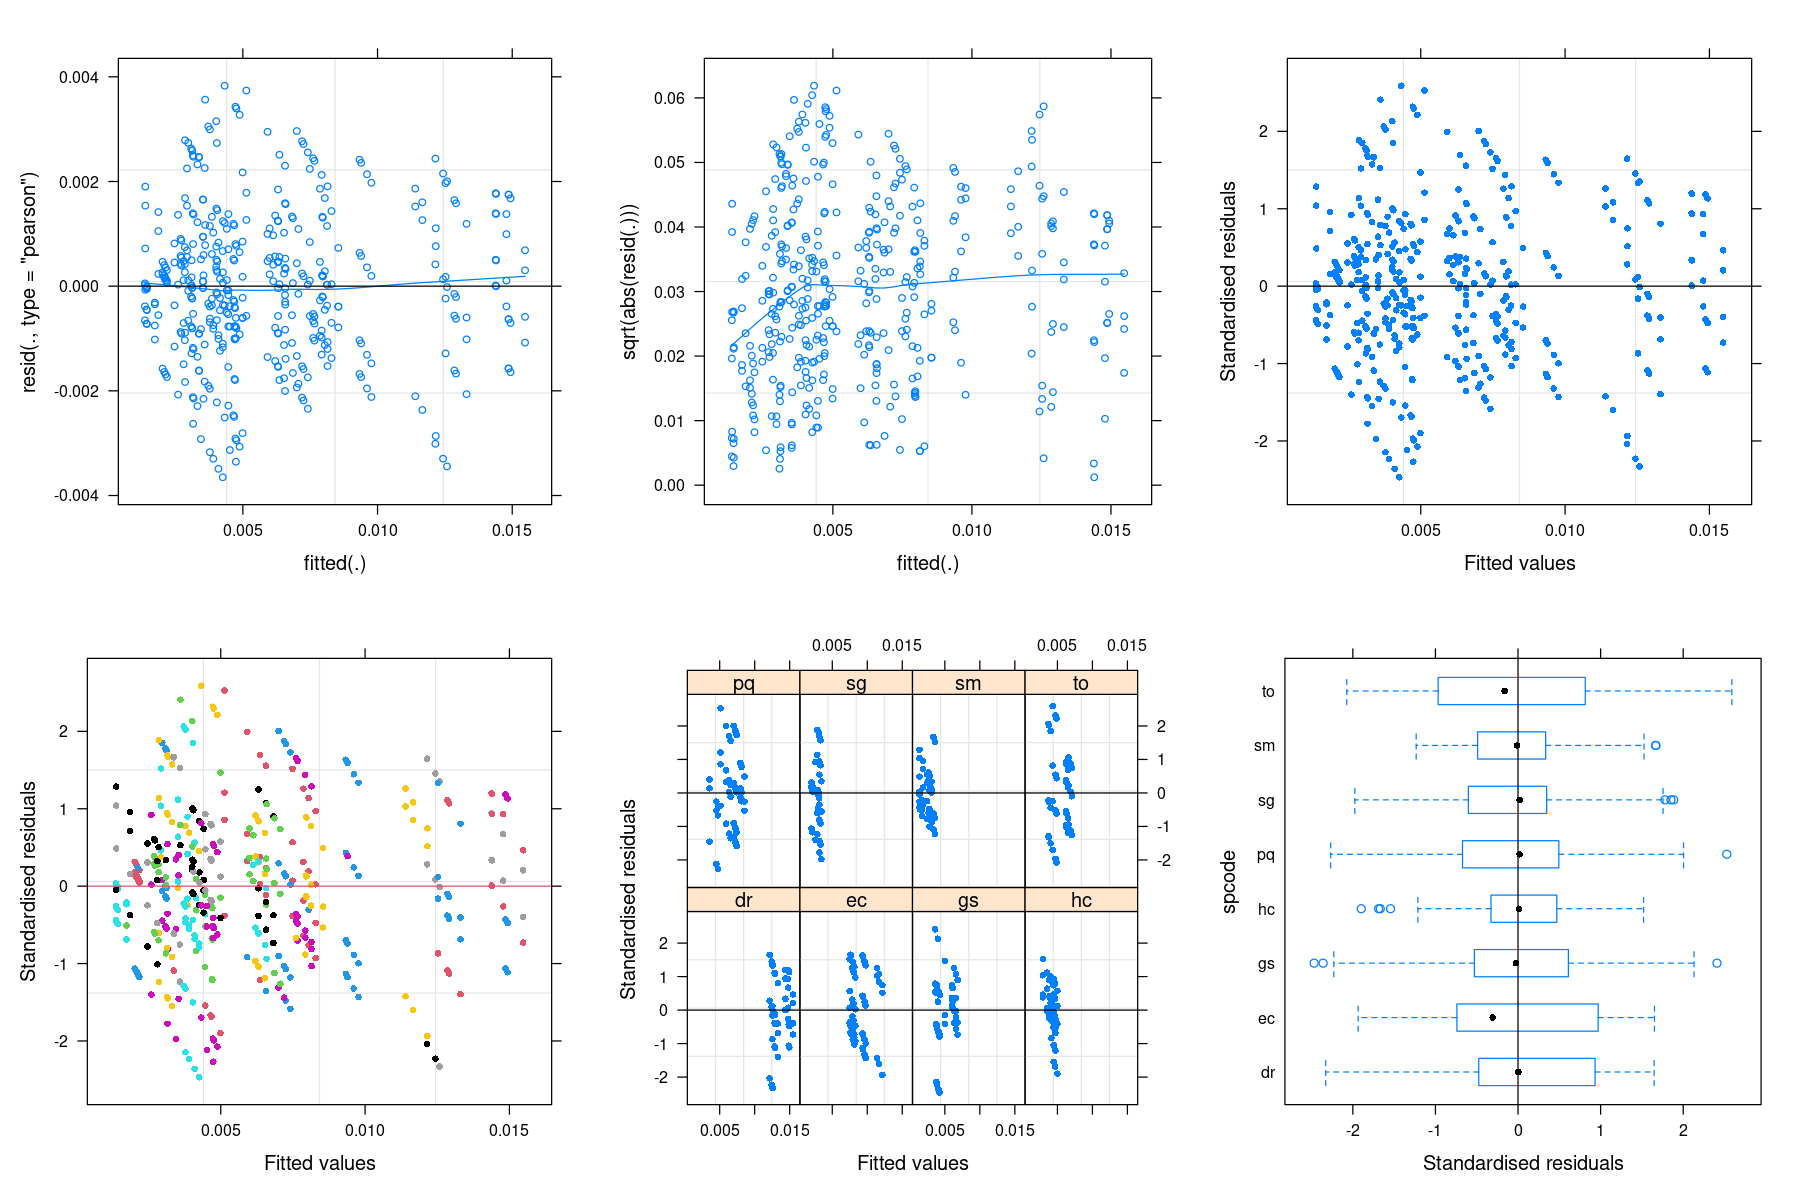

In [288]:
par(mfrow = c(3,3))
validation_plots(model_traits_rgr, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


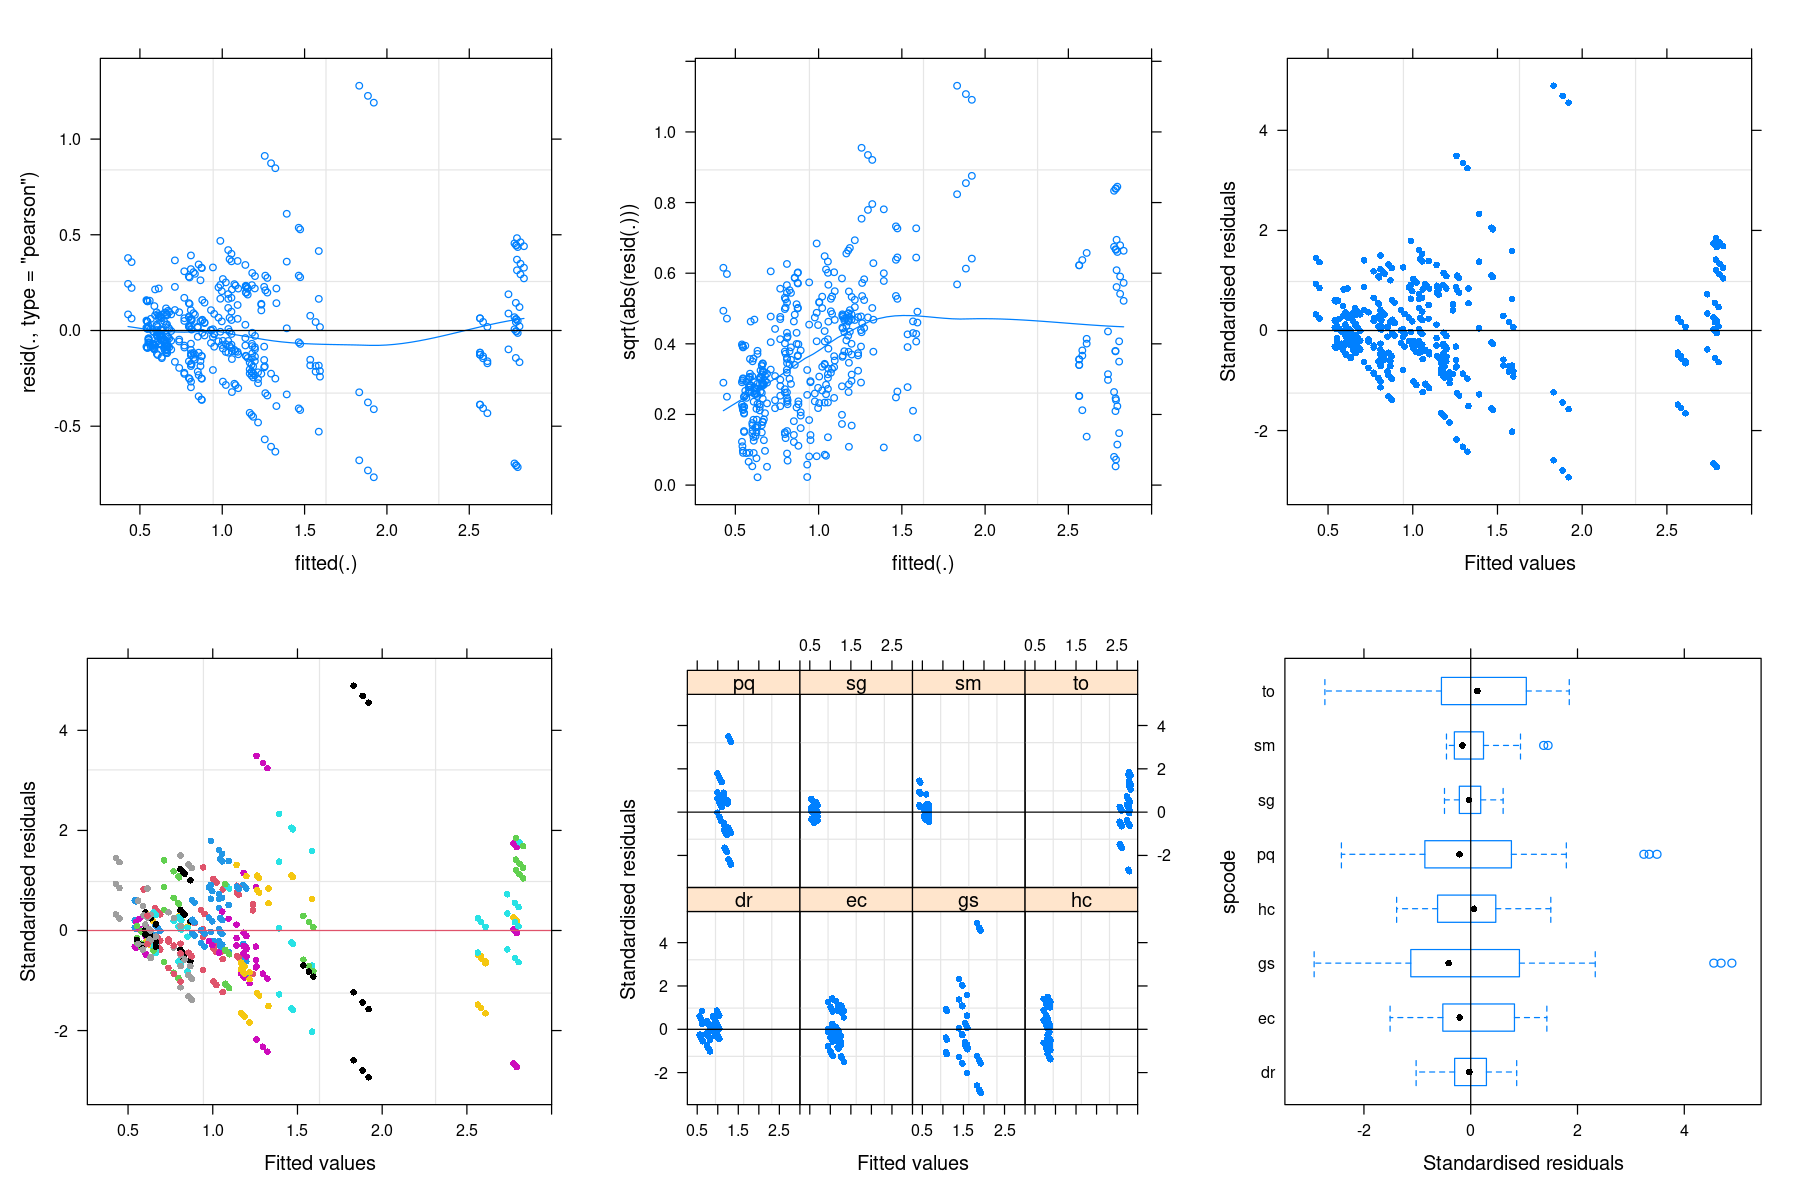

In [289]:
par(mfrow = c(3,3))
validation_plots(model_traits_root_shoot, data = data_for_models,group = "spcode")

## Model inference

In [291]:
## r2 models

r2(model_traits_total_biomass) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8069752|    0.396141|FALSE    |

In [293]:
r2(model_traits_rgr) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8763222|   0.3852113|FALSE    |

In [294]:
r2(model_traits_root_shoot) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8975071|   0.0236171|FALSE    |

## Anova tables

### Total Biomass

In [295]:
Anova(model_traits_total_biomass, type = "III", test.statistic = c("F"))

ERROR: Error in Anova(model_pc_total_biomass, type = "III", test.statistic = c("F")): object 'model_pc_total_biomass' not found


### Contrast plot

In [307]:
traits <-
  set_names(c("amax", "gs","sla", "pnue"))

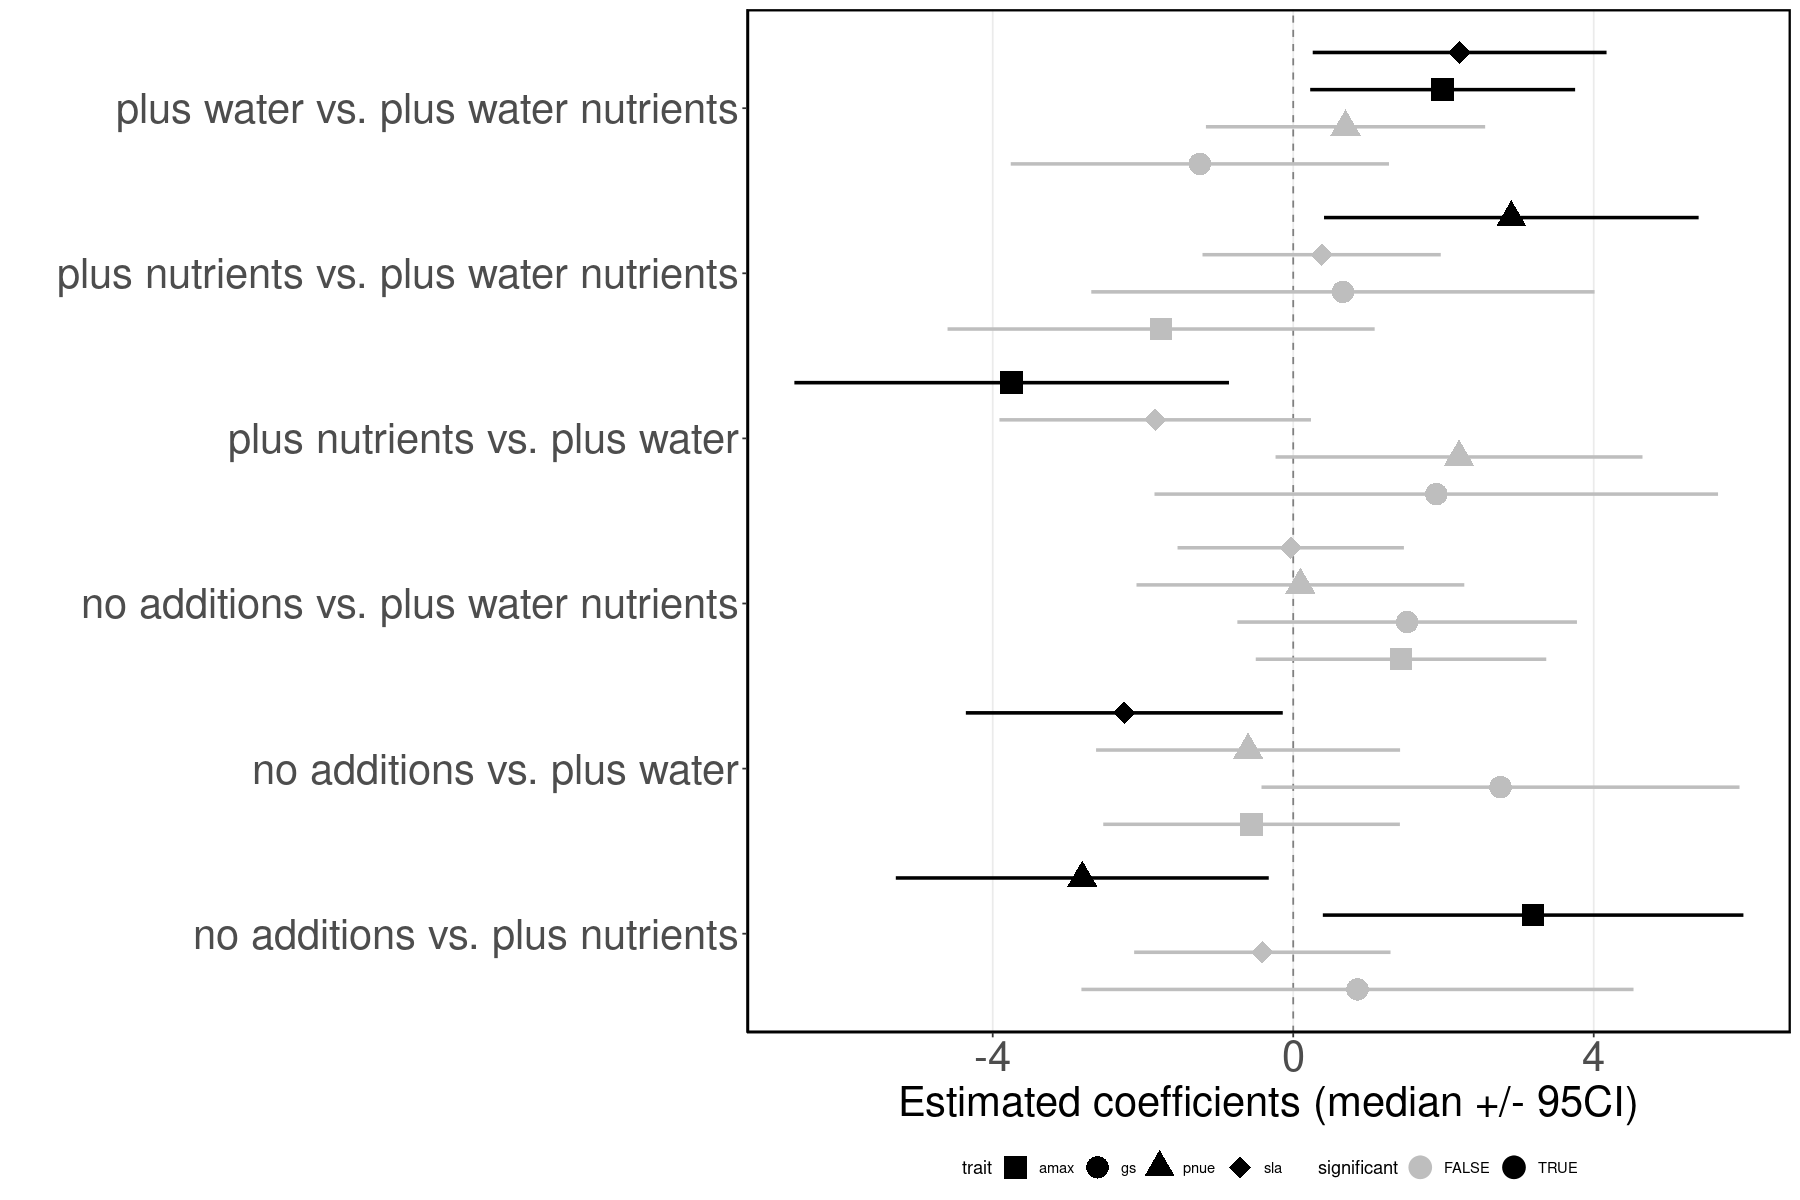

In [309]:
plot_emtrents_contrast(model = model_traits_total_biomass, trait = traits)

#### Amax

In [57]:
total_biomass <- emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "amax")$contrast %>%
        as_tibble() %>%
        tibble::add_column(trait = "amax")


contrast,estimate,SE,df,lower.CL,upper.CL,t.ratio,p.value,response_var
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
no_additions - plus_nutrients,-3.1932972,1.0851155,408.2269,-5.9925089,-0.3940855,-2.9428177,0.018004096,amax
no_additions - plus_water,0.5543627,0.7653880,405.3848,-1.4201229,2.5288482,0.7242897,0.887369567,amax
no_additions - plus_water_nutrients,-1.4346774,0.7495019,408.7378,-3.3681154,0.4987607,-1.9141744,0.223641911,amax
plus_nutrients - plus_water,3.7476599,1.1212856,407.5065,0.8551212,6.6401985,3.3422885,0.005009012,amax
plus_nutrients - plus_water_nutrients,1.7586198,1.1019606,405.9125,-1.0841131,4.6013528,1.5959008,0.382084361,amax
plus_water - plus_water_nutrients,-1.9890400,0.6835027,406.2207,-3.7522696,-0.2258105,-2.9100690,0.019857446,amax


In [30]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "amax")$emtrends %>%
        kable()



|treatment            | amax.trend|       SE|       df|  lower.CL|  upper.CL|
|:--------------------|----------:|--------:|--------:|---------:|---------:|
|no_additions         | -2.0193694| 1.348875| 334.9002| -4.672704| 0.6339653|
|plus_nutrients       |  1.1739278| 1.884347| 359.2170| -2.531811| 4.8796661|
|plus_water           | -2.5737321| 1.344555| 327.2978| -5.218792| 0.0713275|
|plus_water_nutrients | -0.5846921| 1.454170| 321.6287| -3.445578| 2.2761938|

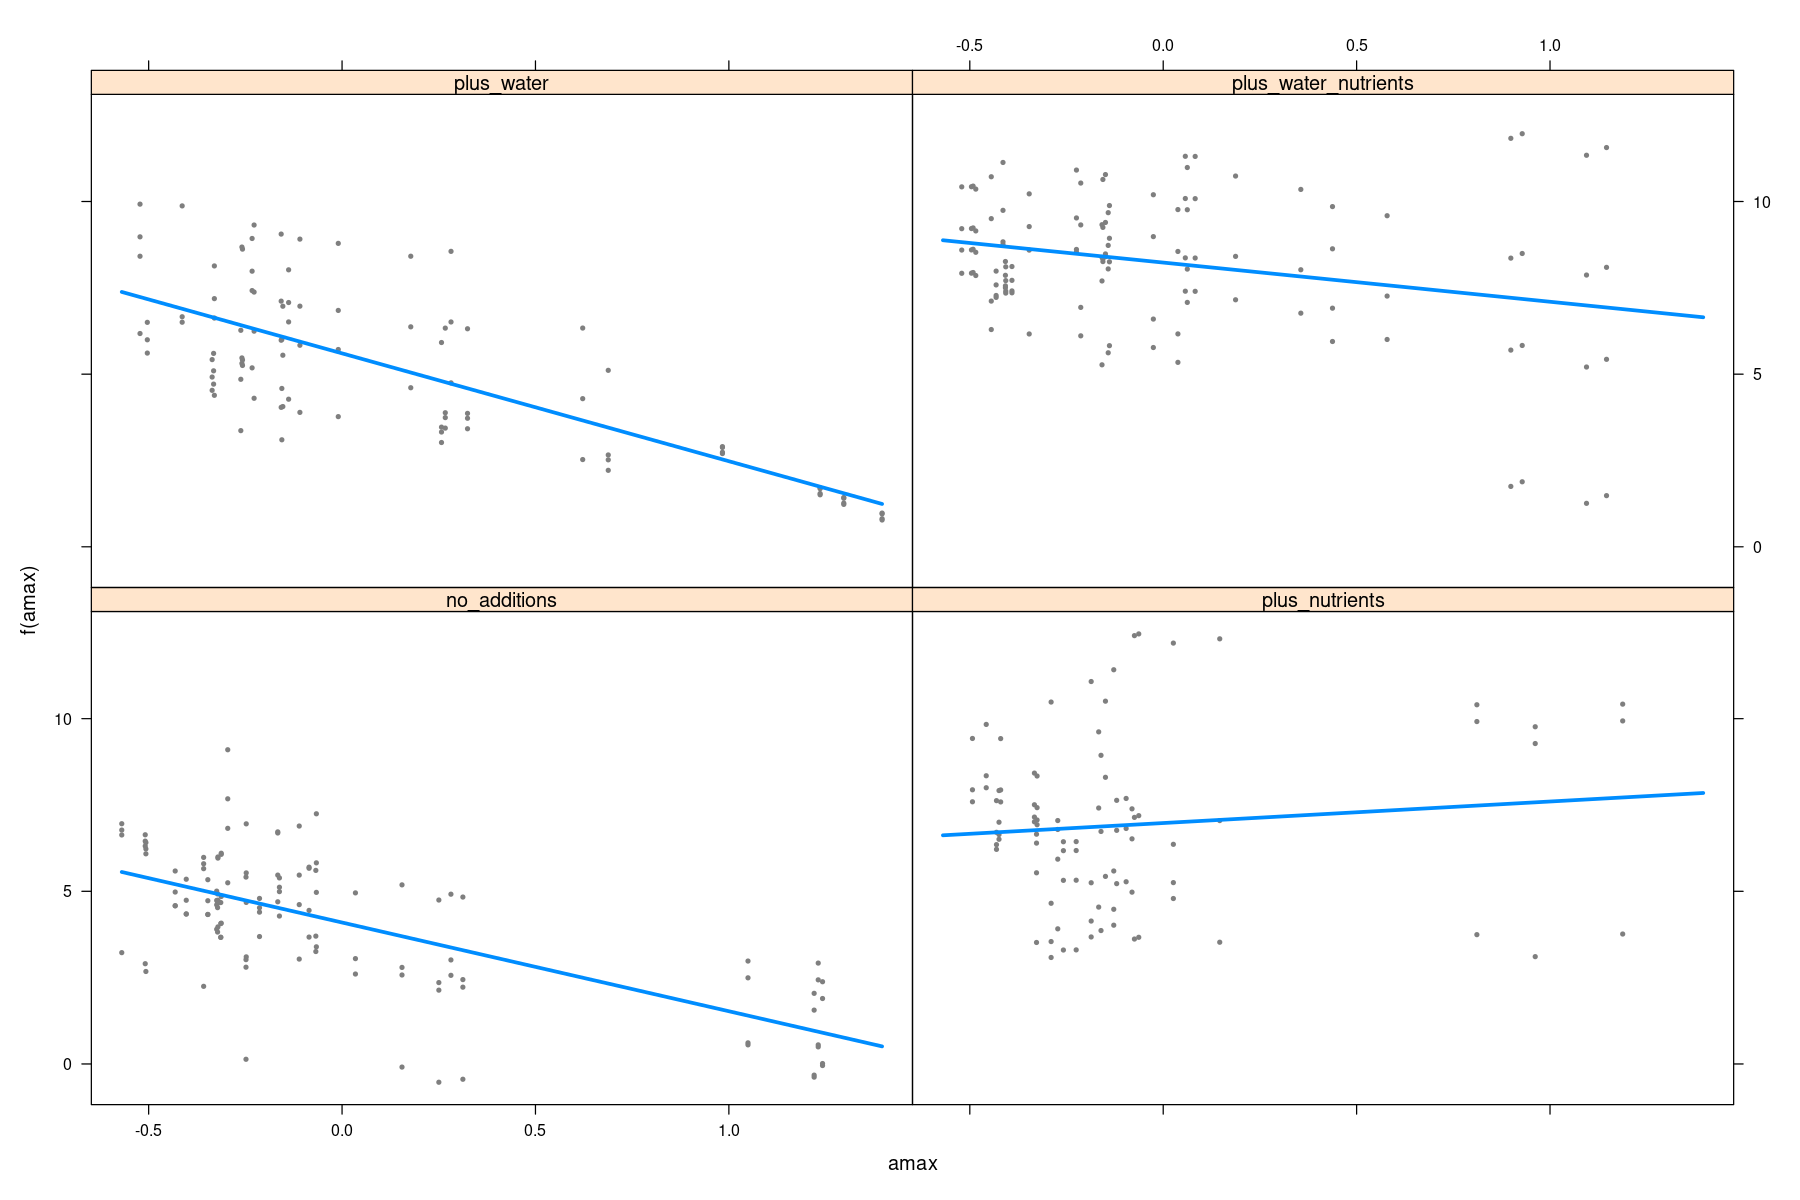

In [31]:
visreg(model_pc_total_biomass, "amax", by = "treatment")

#### gs

In [32]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|  lower.CL|  upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|---------:|---------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.8551437| 1.4243998| 403.6094| -4.529762| 2.8194741| -0.6003537| 0.9319097|
|no_additions - plus_water             | -2.7592296| 1.2332808| 404.6503| -5.940771| 0.4223119| -2.2373084| 0.1150143|
|no_additions - plus_water_nutrients   | -1.5165435| 0.8761112| 405.5070| -3.776661| 0.7435740| -1.7309943| 0.3089198|
|plus_nutrients - plus_water           | -1.9040859| 1.4539168| 404.3461| -5.654822| 1.8466503| -1.3096251| 0.5573048|
|plus_nutrients - plus_water_nutrients | -0.6613998| 1.2983576| 403.7976| -4.010852| 2.6880522| -0.5094127| 0.9568278|
|plus_water - plus_water_nutrients     |  1.2426860| 0.9758562| 404.7701| -1.274764| 3.7601363|  1.2734315| 0.5804084|

#### sla

In [33]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "sla")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         |  0.4112538| 0.6614408| 406.2848| -1.2950616|  2.1175693|  0.6217546| 0.9250864|
|no_additions - plus_water             |  2.2483794| 0.8176415| 405.9782|  0.1391071|  4.3576517|  2.7498351| 0.0315264|
|no_additions - plus_water_nutrients   |  0.0332050| 0.5840141| 407.5000| -1.4733547|  1.5397646|  0.0568564| 0.9999339|
|plus_nutrients - plus_water           |  1.8371255| 0.8037201| 405.4036| -0.2362457|  3.9104968|  2.2857778| 0.1030282|
|plus_nutrients - plus_water_nutrients | -0.3780489| 0.6146901| 405.3650| -1.9637768|  1.2076790| -0.6150235| 0.9272720|
|plus_water - plus_water_nutrients     | -2.2151744| 0.7580466| 403.4598| -4.1707600| -0.2595889| -2.9222142| 0.0191592|

In [34]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "sla")$emtrends %>%
        kable()



|treatment            |  sla.trend|        SE|       df|  lower.CL|   upper.CL|
|:--------------------|----------:|---------:|--------:|---------:|----------:|
|no_additions         | -0.3512734| 0.5133368| 408.9978| -1.360381|  0.6578343|
|plus_nutrients       | -0.7625272| 0.6166866| 408.9823| -1.974798|  0.4497439|
|plus_water           | -2.5996527| 0.7901996| 408.9685| -4.153012| -1.0462930|
|plus_water_nutrients | -0.3844783| 0.5385676| 404.3300| -1.443221|  0.6742639|

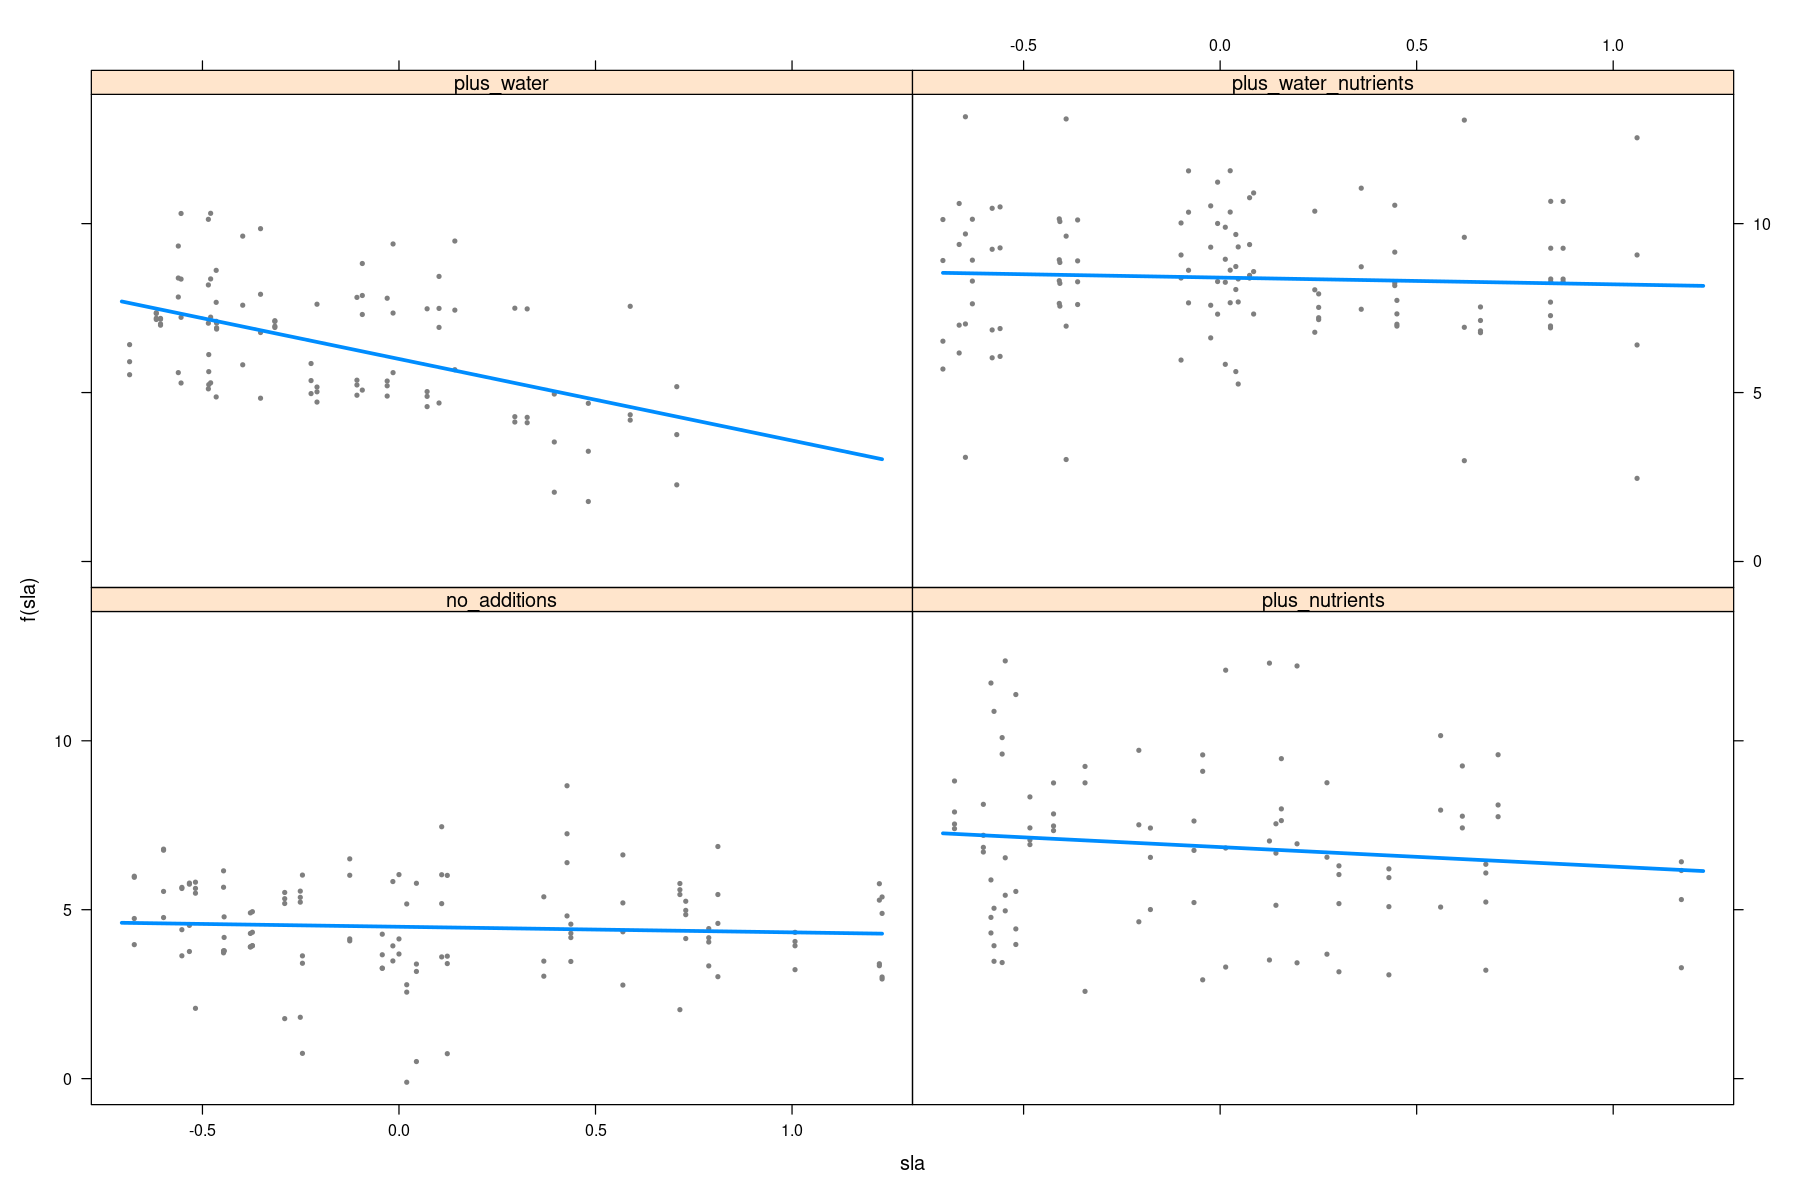

In [513]:
visreg(model_pc_total_biomass, "sla", by = "treatment")

#### PNUE

In [35]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         |  2.8077891| 0.9621796| 406.8157|  0.3256727|  5.2899055|  2.9181549| 0.0193846|
|no_additions - plus_water             |  0.6009377| 0.7843785| 407.8339| -1.4224877|  2.6243632|  0.7661323| 0.8696623|
|no_additions - plus_water_nutrients   | -0.0954730| 0.8457109| 408.3431| -2.2771034|  2.0861573| -0.1128909| 0.9994848|
|plus_nutrients - plus_water           | -2.2068514| 0.9467588| 408.8820| -4.6491358|  0.2354330| -2.3309543| 0.0927519|
|plus_nutrients - plus_water_nutrients | -2.9032621| 0.9664852| 407.2692| -5.3964741| -0.4100502| -3.0039385| 0.0149595|
|plus_water - plus_water_nutrients     | -0.6964108| 0.7204126| 404.4426| -2.5548906|  1.1620691| -0.9666832| 0.7684757|

In [36]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pnue")$emtrends %>%
        kable()



|treatment            | pnue.trend|        SE|       df|   lower.CL|   upper.CL|
|:--------------------|----------:|---------:|--------:|----------:|----------:|
|no_additions         |  0.9372171| 0.6620249| 397.7972| -0.3642877|  2.2387219|
|plus_nutrients       | -1.8705720| 0.8737145| 408.0175| -3.5881157| -0.1530283|
|plus_water           |  0.3362794| 0.6188580| 396.0436| -0.8803782|  1.5529369|
|plus_water_nutrients |  1.0326901| 0.7178114| 406.8553| -0.3783921|  2.4437723|

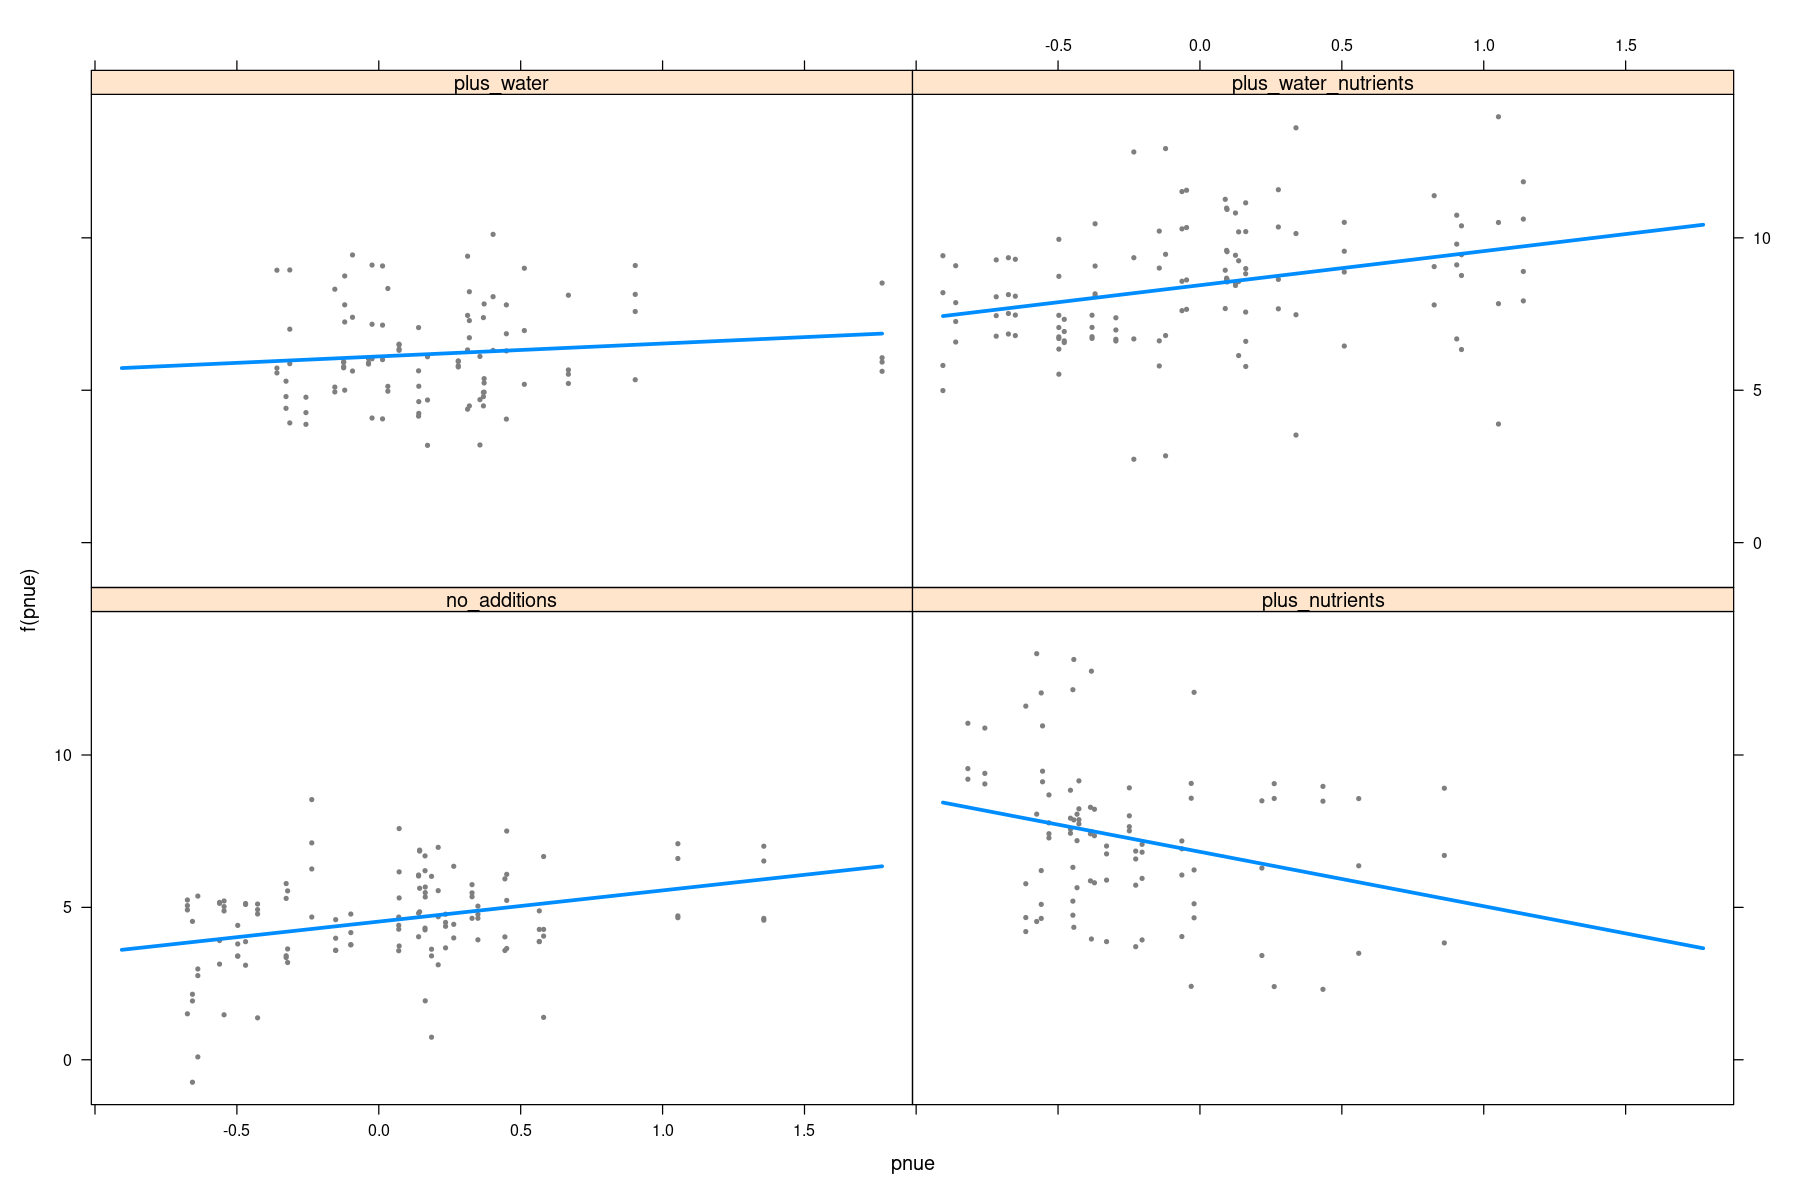

In [37]:

visreg(model_pc_total_biomass, "pnue", by = "treatment")

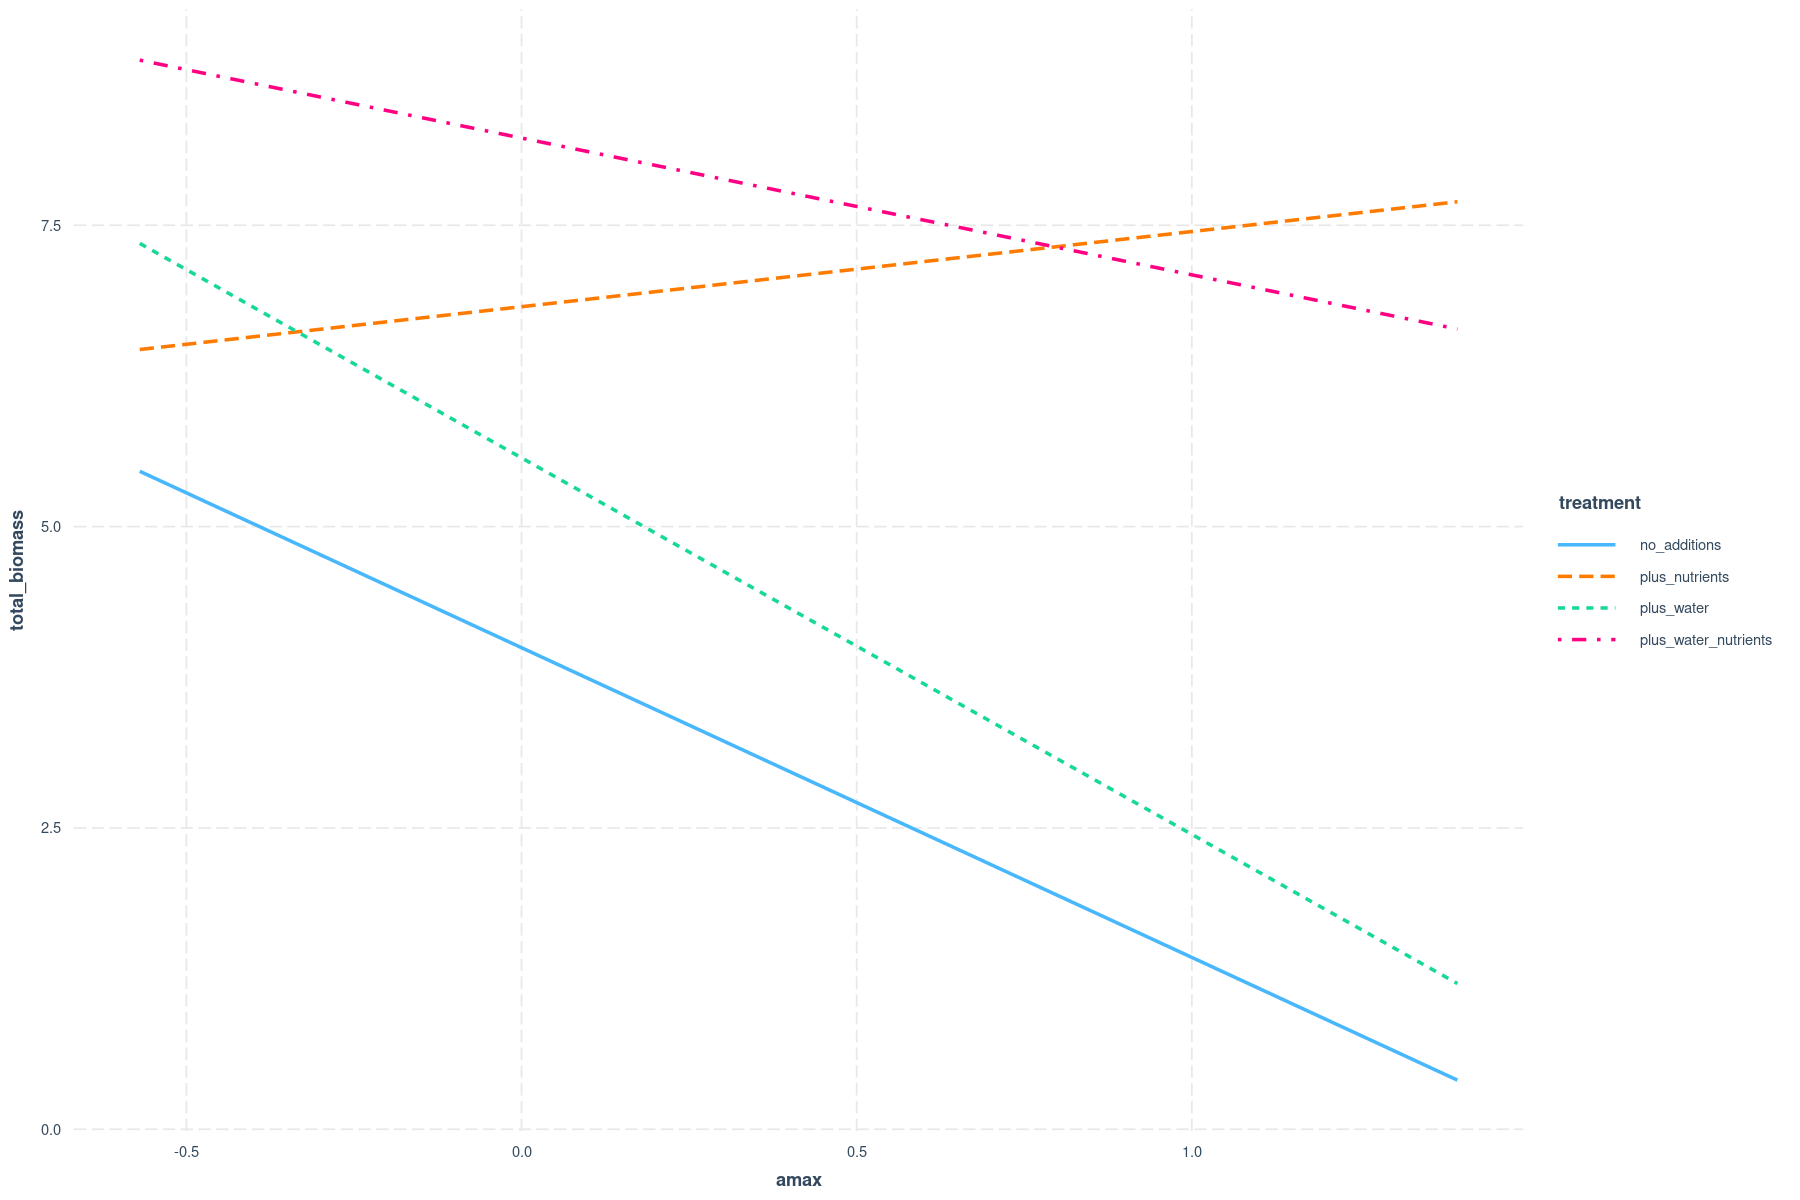

In [239]:
interact_plot(model_pc_total_biomass, pred = "amax", modx = treatment,
                plot.points = FALSE, jitter = 0.5)

### RGR 

In [259]:
Anova(model_pc_rgr, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.976194232,1,7.414332,1.257529e-01
treatment,26.780045682,3,405.169441,8.052464e-16
amax,1.259819742,1,408.698049,2.623442e-01
gs,5.256039529,1,404.220641,2.238367e-02
sla,0.005020749,1,408.900602,9.435460e-01
pnue,1.790849882,1,408.022531,1.815679e-01
nfixer,6.459094975,1,6.884749,3.911730e-02
init_height,1.483513086,1,377.338941,2.239867e-01
treatment:amax,3.904677972,3,405.614281,9.043488e-03


### Contrast plot

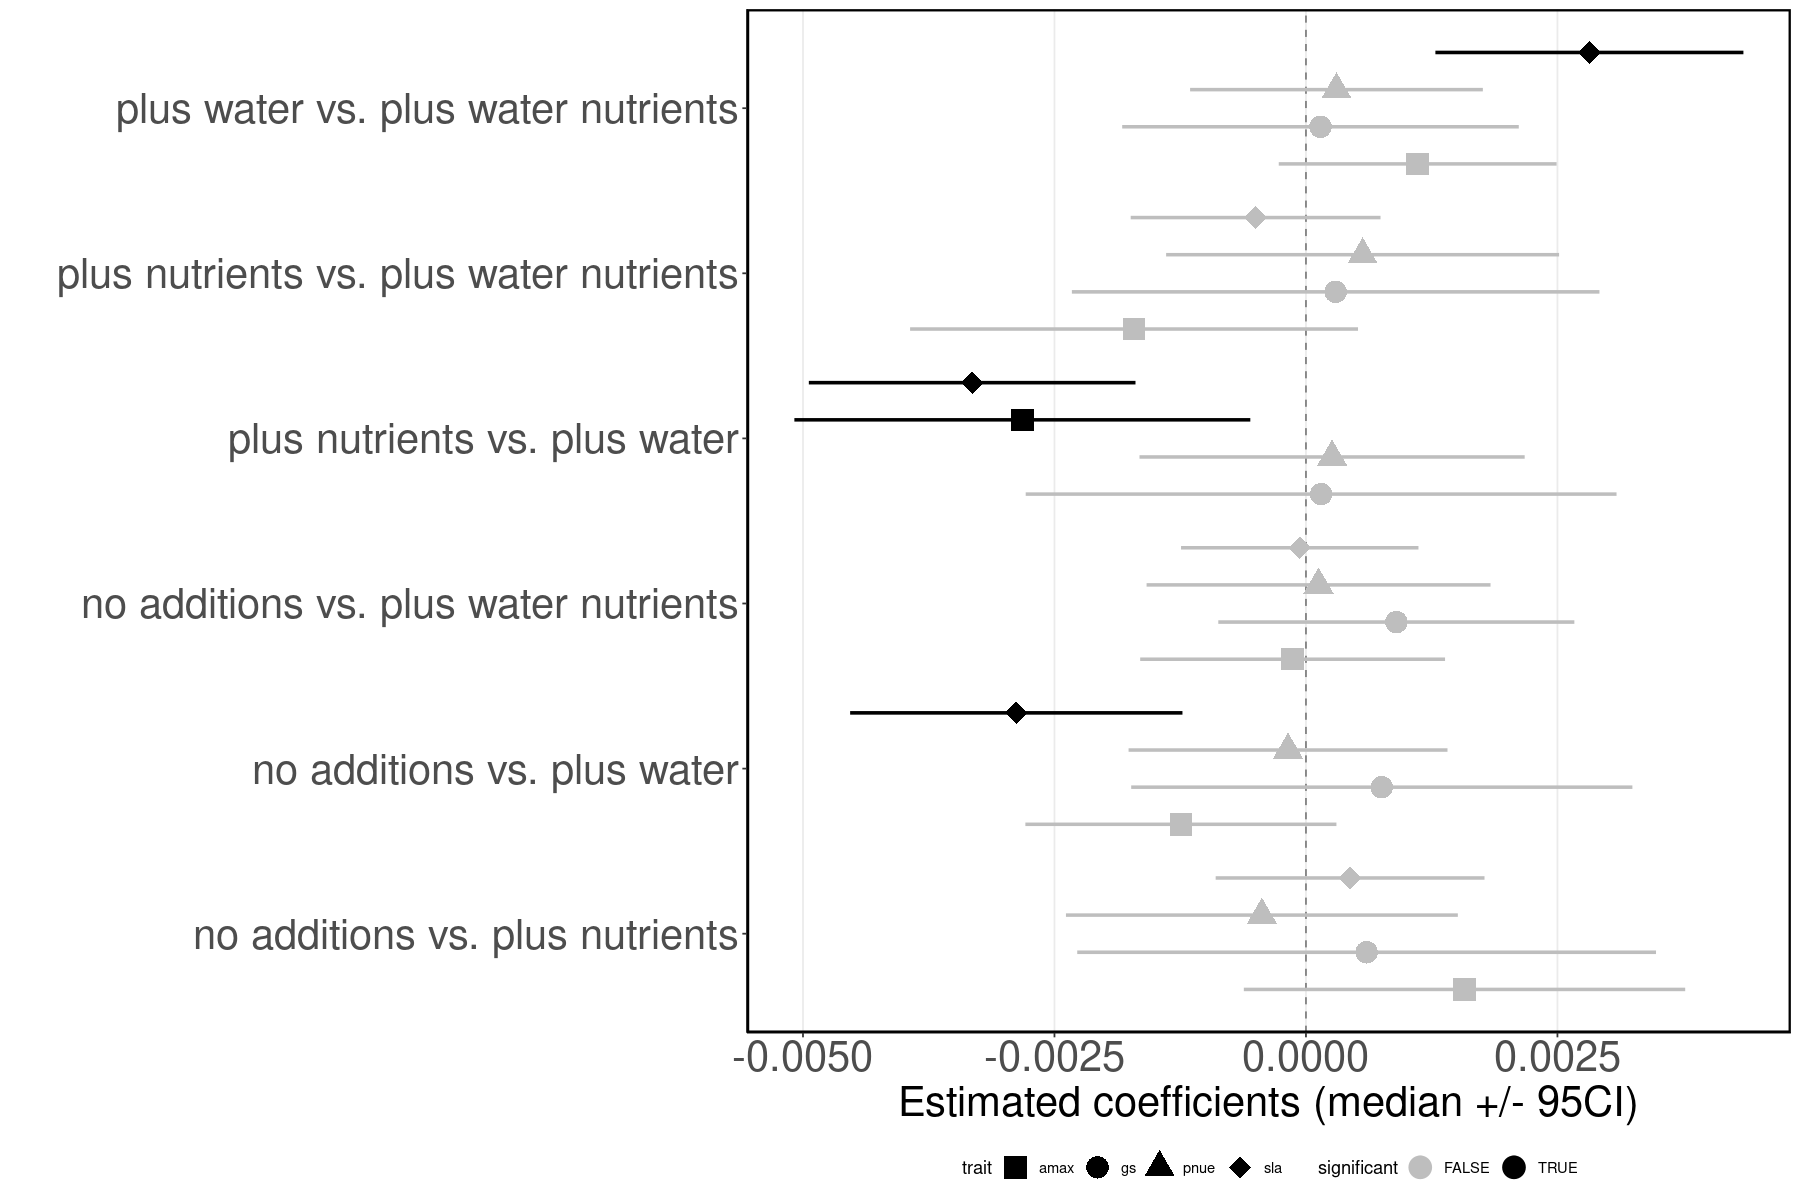

In [310]:
plot_emtrents_contrast(model = model_traits_rgr, trait = traits)

#### Amax

In [48]:
emtrends(model_pc_rgr,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|  upper.CL|   t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|---------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.0008931| 0.0004534| 405.0045| -0.0020627| 0.0002765| -1.969886| 0.2011501|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             |  0.0002796| 0.0002730| 403.9750| -0.0004246| 0.0009839|  1.024294| 0.7353055|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.0003793| 0.0002663| 406.4248| -0.0010663| 0.0003076| -1.424509| 0.4847331|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.0011727| 0.0004497| 404.5281|  0.00

#### gs

In [262]:
emtrends(model_pc_rgr,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(gs-0.00225785452521475 no_additions) - (gs-0.00225785452521475 plus_nutrients)         | -0.0006031| 0.0011151| 403.3320| -0.0034799| 0.0022737| -0.5407962| 0.9489715|
|(gs-0.00225785452521475 no_additions) - (gs-0.00225785452521475 plus_water)             | -0.0007539| 0.0009657| 403.9919| -0.0032451| 0.0017374| -0.7806371| 0.8632239|
|(gs-0.00225785452521475 no_additions) - (gs-0.00225785452521475 plus_water_nutrients)   | -0.0008983| 0.0006860| 404.4547| -0.0026681| 0.0008715| -1.3094431| 0.5574207|
|(gs-0.00225785452521475 plus_nutrients) - (gs-0.00225785452521475 plus_water)           | -0.0001508| 0.0011384| 403.7933| -0.0030875| 0.0027860| -

#### sla

In [264]:
emtrends(model_pc_rgr,
        pairwise ~ sla*treatment,
        var = "sla")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(sla-0.0081903083973318 no_additions) - (sla-0.0081903083973318 plus_nutrients)         | -0.0004387| 0.0005180| 404.9707| -0.0017750|  0.0008976| -0.8469781| 0.8319109|
|(sla-0.0081903083973318 no_additions) - (sla-0.0081903083973318 plus_water)             |  0.0028795| 0.0006403| 404.7650|  0.0012277|  0.0045313|  4.4972051| 0.0000531|
|(sla-0.0081903083973318 no_additions) - (sla-0.0081903083973318 plus_water_nutrients)   |  0.0000618| 0.0004575| 405.8526| -0.0011183|  0.0012419|  0.1350489| 0.9991198|
|(sla-0.0081903083973318 plus_nutrients) - (sla-0.0081903083973318 plus_water)           |  0.0033183| 0.0006294| 404.4434|  0.0016946|  0.0049

#### PNUE

In [265]:
emtrends(model_pc_rgr,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|pnue0.000897910590226286 no_additions - pnue0.000897910590226286 plus_nutrients         |  0.0004380| 0.0007551| 408.9698| -0.0015099| 0.0023858|  0.5800121| 0.9380567|
|pnue0.000897910590226286 no_additions - pnue0.000897910590226286 plus_water             |  0.0001782| 0.0006145| 406.1856| -0.0014070| 0.0017634|  0.2899359| 0.9915029|
|pnue0.000897910590226286 no_additions - pnue0.000897910590226286 plus_water_nutrients   | -0.0001253| 0.0006627| 406.7118| -0.0018348| 0.0015843| -0.1890375| 0.9976017|
|pnue0.000897910590226286 plus_nutrients - pnue0.000897910590226286 plus_water           | -0.0002598| 0.0007422| 407.5150| -0.0021744| 0.0016548| -

### Root to shoot ratio 

In [46]:
Anova(model_pc_root_shoot, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.196615e+01,1,6.661786,1.141589e-02
treatment,2.459689e+00,3,404.187384,6.232556e-02
amax,1.272098e-01,1,407.880233,7.215272e-01
gs,7.921293e-01,1,403.597890,3.739872e-01
sla,3.431577e-03,1,406.920143,9.533157e-01
pnue,2.430546e-03,1,405.906524,9.607040e-01
nfixer,4.500816e-02,1,6.451648,8.385342e-01
init_height,6.257118e-08,1,406.503397,9.998005e-01
treatment:amax,6.596698e+00,3,404.422532,2.319827e-04


### Constrast plot

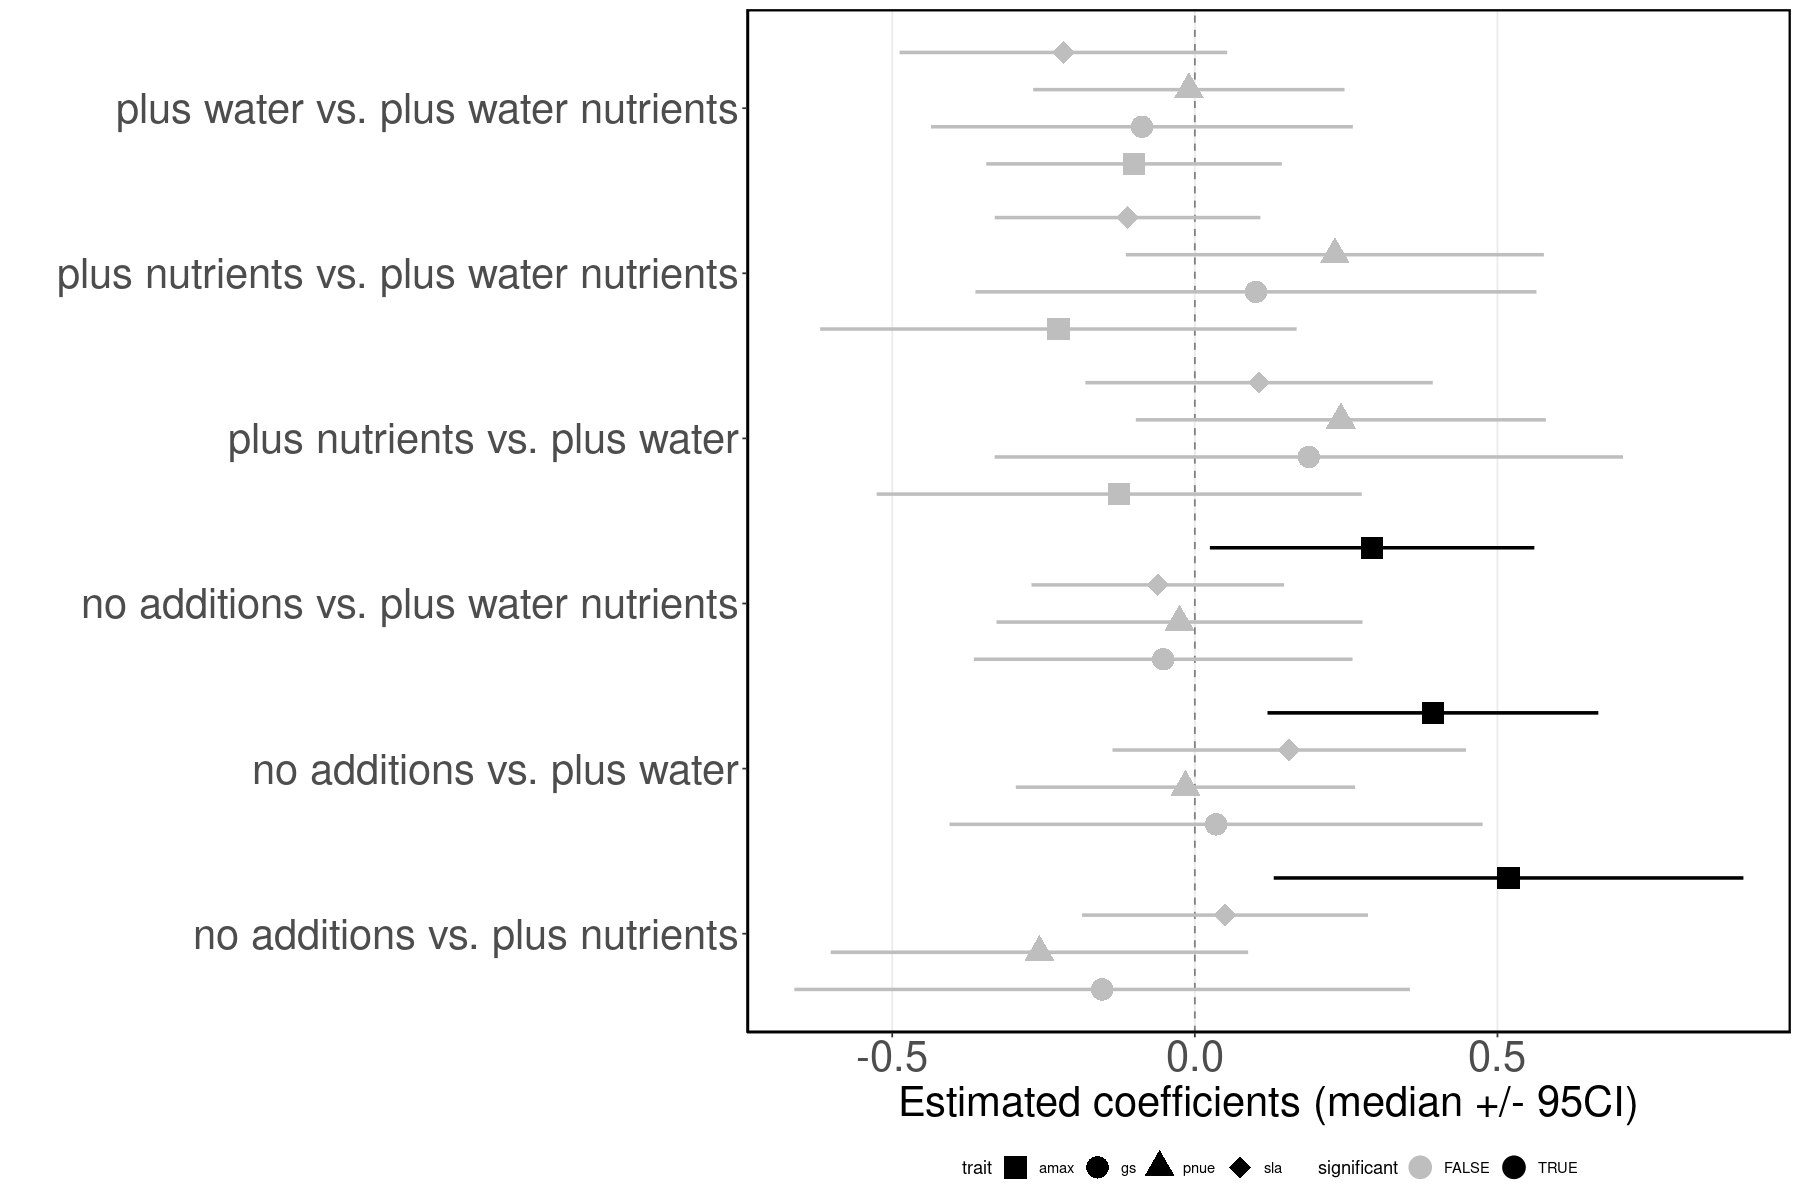

In [314]:
plot_emtrents_contrast(model = model_traits_root_shoot, trait = traits)

#### Amax

In [267]:
emtrends(model_pc_root_shoot,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|(amax-0.00138857062569367 no_additions) - (amax-0.00138857062569367 plus_nutrients)         | -0.5183622| 0.1504083| 405.0717| -0.9063745| -0.1303498| -3.4463668| 0.0034994|
|(amax-0.00138857062569367 no_additions) - (amax-0.00138857062569367 plus_water)             | -0.3933564| 0.1059501| 403.6941| -0.6666826| -0.1200302| -3.7126572| 0.0013326|
|(amax-0.00138857062569367 no_additions) - (amax-0.00138857062569367 plus_water_nutrients)   | -0.2928981| 0.1038938| 405.3505| -0.5609149| -0.0248813| -2.8192071| 0.0258951|
|(amax-0.00138857062569367 plus_nutrients) - (amax-0.00138857062569367 plus_water)           |  0.1250058| 0.1553450| 404.6

#### gs

In [268]:
emtrends(model_pc_root_shoot,
        pairwise ~ gs:treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                                                                                |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:---------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(gs-0.00225785452521475 no_additions) - (gs-0.00225785452521475 plus_nutrients)         |  0.1531817| 0.1971051| 403.1557| -0.3553057| 0.6616692|  0.7771575| 0.8647820|
|(gs-0.00225785452521475 no_additions) - (gs-0.00225785452521475 plus_water)             | -0.0351148| 0.1707062| 403.5002| -0.4754972| 0.4052676| -0.2057033| 0.9969175|
|(gs-0.00225785452521475 no_additions) - (gs-0.00225785452521475 plus_water_nutrients)   |  0.0522765| 0.1212736| 403.7106| -0.2605808| 0.3651337|  0.4310623| 0.9731168|
|(gs-0.00225785452521475 plus_nutrients) - (gs-0.00225785452521475 plus_water)           | -0.1882965| 0.2012277| 403.3948| -0.7074180| 0.3308249| -

#### d13c

In [269]:
emtrends(model_pc_root_shoot,
        pairwise ~ slatreatment,
        var = "d13c")$contrast %>%
        kable()

ERROR: Error in emtrends(model_pc_root_shoot, pairwise ~ d13c * treatment, var = "d13c"): Variable 'd13c' is not in the dataset


#### PNUE

In [59]:
emtrends(model_pc_root_shoot,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  0.1969485| 0.0598803| 403.7773|  0.0424715|  0.3514254|  3.2890349| 0.0059993|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.0083926| 0.0468496| 404.9865| -0.1124666|  0.1292518|  0.1791397| 0.9979563|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   |  0.0174529| 0.0498758| 403.3815| -0.1112152|  0.1461210|  0.3499275| 0.9852749|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -0.1885559| 0.0635804| 404.5045| -0.3525769| -0.0245348| -2.9656